* #### Realizando os testes de hipóteses

In [123]:
# Importando as bibliotecas.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import library as lib
import warnings
warnings.filterwarnings('ignore')
sns.set_theme(style="white")

In [4]:
# Bibliotecas para testes de hipoteses.
import scipy.stats as stats
from scipy.stats import f_oneway, sem, t, ttest_ind, chi2_contingency, norm, contingency
from statsmodels.stats.proportion import proportion_confint, proportions_ztest
import statsmodels.stats.api as sms
import pingouin as pg

In [5]:
# Carregando nossos datasets.
df_trial_metricas = pd.read_csv(r'..\dados\df_trial_metricas.csv')
df_funcionalidade_metricas = pd.read_csv(r'..\dados\df_funcionalidade_metricas.csv')

In [6]:
df_trial_metricas.head()

,id_clinica,id_canal,data_inicio_trial,data_fim_trial,num_dias_trial,total_atividades_realizadas,solicitou_credenciamento,credenciamento_aprovado,credenciamento_status,realizou_assinatura,data_assinatura,status_assinatura,num_dias_para_assinatura,nom_canal
0,9825,0,2023-08-21,2023-08-25,4,173,True,True,Concluído,True,2023-08-25,active,4.0,Paid - meta
1,9984,1,2023-08-24,2023-08-31,7,14,True,True,Concluído,False,NaN,NaN,NaN,Paid - google
2,9986,1,2023-08-24,2023-09-14,21,4,True,True,Concluído,False,NaN,NaN,NaN,Paid - google
3,9988,1,2023-08-24,2023-08-31,7,1,False,False,Não aderiu ao plano,False,NaN,NaN,NaN,Paid - google
4,9690,2,2023-08-17,2023-08-24,7,1,False,False,Não aderiu ao plano,False,NaN,NaN,NaN,Other


In [7]:
df_funcionalidade_metricas.head()

,id_clinica,id_funcionalidade,num_qtde_vezes,nom_funcionalidade
0,8994,5,1,budget_management
1,8994,2,2,medical_record
2,8994,9,1,revenue_management
3,8994,1,1,scheduling
4,8998,3,2,anamnese


In [8]:
def teste_chi2(dataframe: pd.DataFrame, coluna1: str , coluna2: str) -> None:
    """Calcula o teste de hipoteses qui-quadrado - variáveis categóricas Associação : proporção : +2 categorias : 2 amostras.
    Args: *vars_cat
        var1 : pandas series : variável categórica do dataframe.
        var2 : pandas series : variável categórica do dataframe.        
    """
        
    # var1, var2 = vars_cat
    table = pd.crosstab(dataframe[coluna1], dataframe[coluna2])
    alpha = 0.05
    
    print('***** Realizando a teste de hipóteses qui-quadrado *****')
    print('* Premissas:')
    print('- As observações devem ser contagens ou frequências.')
    print('- Cada observação deve pertencer a uma única categoria.')
    print('- A amostra deve ser relativamente grande, com pelo menos 5 observações em cada célula e, no caso de poucos grupos, pelo menos 10.') 
    print('- Os dados devem vir de uma amostra aleatória.') 
    print('- As categorias das variáveis devem ser mutuamente exclusivas.')
    print('')
    
    # Hipóteses
    print('----- Hipóteses -----')
    print(f'H0 : as variáveis {coluna1} e {coluna2} são independentes. As proporções são estatisticamente iguais.')
    print(f'Ha : as variáveis {coluna1} e {coluna2} são dependentes. As proporções são estatisticamente diferentes.')
    print(f'Nível de significância de {alpha}.')
    print('---------------------')
    print('')
        
    # Executando o Teste qui-quadrado
    chi2, p_valor, _, _ = chi2_contingency(table)
    print(f"Valor do teste qui-quadrado: {chi2}")
    print(f"P_valor: {p_valor}")
    print('')
    print('----- Conclusão -----')
    if p_valor < alpha:
        print(f"- p_valor: {p_valor:.10f} < alpha: 0.05 => Rejeitamos a hipótese nula. Há evidência suficiente, ao nível de significância de {alpha}, para concluir que as variáveis {coluna1} e {coluna2} são dependentes.")
        print(f"- Tamanho do Efeito - Cramér´s V: {contingency.association(table,method='cramer'):.10f}")        
    else:
        print(f"- p_valor: {p_valor:.10f} > alpha: 0.05 => Não rejeitamos a hipótese nula. Há evidência suficiente, ao nível de significância de {alpha}, para concluir que as variáveis {coluna1} e {coluna2} são independentes.")

In [9]:
def difmedia_2amostras(**kargs):
    """Realiza o teste de hipóteses T para diferença das médias entre dua amostras.
    kargs:
         var1: pandas series : variável categórica do dataframe.
         var2: pandas series : variável categórica do dataframe.
         var3: string : nome data variável alvo do dataframe.    
    """
    alpha = 0.05
    l_keys = list(kargs.keys())
    l_values = list(kargs.values())
    
    print('***** Realizando o teste de hipóteses t : Média - 2 amostras *****')
    print('* Premissas:')
    print('- Dados sejam normais ou que tenhamos pelo menos 15 dados em cada grupo.')
    print('- Grupos com variâncias diferentes.')
    print('')

    # Hipóteses
    print('----- Hipóteses ----------------------------------------------------------------')
    print(f'H0 : A média do {kargs["var"]} entre {l_keys[0]} e {l_keys[1]}, são iguais.')
    print(f'Ha : A média do {kargs["var"]} entre {l_keys[0]} e {l_keys[1]}, são diferentes.')
    print(f'Nível de significância de {alpha}.')
    print('--------------------------------------------------------------------------------')
    print('')

    # Teste de hipóteses T - média - 2 amostras
    t = pg.ttest(l_values[0],l_values[1], paired=False, correction = True).round(15)
    
    print('----- Resultados -----')
    print(f"Valor do estatística T: {t['T'].iloc[0]}")
    print(f"P_valor: {t['p-val'].iloc[0]}")
    print(f'Intervalo de confiança para diferença das médias: {t["CI95%"].iloc[0]}')
    print('')
    print('----- Conclusão -----')
    if t['p-val'].iloc[0] < alpha: 
        print(f"- p_valor: {t['p-val'].iloc[0]} < alpha: 0.05 => Rejeitamos a hipótese nula. Existe diferença estatisticamente significativa das médias do {kargs['var']} entre {l_keys[0]} e {l_keys[1]}.")
    else:
        print(f"- p_valor: {t['p-val'].iloc[0]} > alpha: 0.05 => Não rejeitamos a hipótese nula. Não existe diferença estatisticamente significativa das médias do {kargs['var']} entre {l_keys[0]} e {l_keys[1]}.")
    # Intervalo de confiança 
    if t['CI95%'].iloc[0][0] <= 0 <= t['CI95%'].iloc[0][1]: print(f'- Intervalo de confiança {t["CI95%"].iloc[0]} passa pelo zero. As amostras são estatisticamente iguais.')
    else:
        print(f'- Intervalo de confiança {t["CI95%"].iloc[0]} não passa pelo zero. As amostras são estatisticamente diferentes.')
        
    # Médias dos grupos
    print(f'- Média do {kargs["var"]} para {l_keys[0]}: {l_values[0].mean()}')
    print(f'- Média do {kargs["var"]} para {l_keys[1]}: {l_values[1].mean()}')

In [11]:
def variancia(**kargs):
    """Realiza o teste de hipóteses Bartlett de igualdade de variâncias.
    kargs:
         dv : string : nome da variável dependente do dataframe.
         fator : string : nome data variável independente do dataframe.
         data : nome do dataframe.
    """
    alpha = 0.05
    print('***** Realizando o teste de hipóteses Bartlett de igualdade de variâncias. *****')
    print('* Premissas:')
    print('- Dados sejam normais ou que tenhamos pelo menos 15 dados em cada grupo.')
    print('')
    # Hipóteses
    print('----- Hipóteses -------------------------------------------------------------------------')
    print(f'H0 : As variâncias de todas as amostras da {kargs["fator"]} são iguais.')
    print(f'Ha : As variâncias para um par ou mais das amostras da {kargs["fator"]} são diferentes.')
    print(f'Nível de significância de {alpha}.')
    print('-----------------------------------------------------------------------------------------')
    print('')
    # Teste de Bartlett
    bartlett = pg.homoscedasticity(data=kargs['data'], dv=kargs['dv'], group=kargs['fator'], method="bartlett", alpha=.05)

    print('----- Resultados -----')
    print(f"Valor do estatística T: {bartlett['T'].iloc[0]}")
    print(f"P_valor: {bartlett['pval'].iloc[0]}")
    print('')
    print('----- Conclusão -----')
    if bartlett['pval'].iloc[0] < alpha: 
        print(f"- p_valor: {bartlett['pval'].iloc[0]} < alpha: 0.05 => Rejeitamos a hipótese nula. As variâncias das amostras da {kargs['fator']} são diferentes.")
    else:
        print(f"- p_valor: {bartlett['pval'].iloc[0]} > alpha: 0.05 => Não rejeitamos a hipótese nula. As variâncias das amostras da {kargs['fator']} são iguais.")
    

In [12]:
def anova(**kargs):
    """Realiza o teste de hipóteses ANOVA ou ANOVA Welch para diferença entre as médias de duas amostras e um fator.
    kargs:
         dv : string : nome da variável dependente do dataframe.
         fator : string : nome data variável independente do dataframe.
         data : nome do dataframe.
         var_iguais : boolean : True => teste ANOVA, False => teste ANOVA Welch.
    """
    alpha = 0.05
    if kargs['var_iguais']:
        variancias = 'iguais'
        teste = 'ANOVA'
        # Teste de hipóteste ANOVA oneway
        anova = pg.anova(dv=kargs["dv"], between=kargs["fator"], data=kargs["data"], detailed=False)
    else:
        variancias = 'diferentes'
        teste = 'ANOVA WELCH'
        # Teste de hipóteste ANOVA Welch
        anova = pg.welch_anova(dv=kargs["dv"], between=kargs["fator"], data=kargs["data"])        
    
    print(f'***** Realizando o teste de hipóteses {teste} : Médias : +2 amostras : 1 fator *****')
    print('* Premissas:')
    print('- Amostras aleatórias.')
    print('- Grupos independentes.')
    print('- Variável dependente é continua.')
    print('- Variável independente é categórica.')
    print('- Dados sejam normais ou que tenhamos pelo menos 15 dados em cada grupo.')
    print(f'- Grupos com variâncias {variancias}.')
    print('')

    # Hipóteses
    print('----- Hipóteses -----------------------------------------------------------------------')
    print(f'H0 : As médias da {kargs["dv"]} entre as amostras da {kargs["fator"]} são iguais.')
    print(f'Ha : As médias da {kargs["dv"]} entre as amostras da {kargs["fator"]} são diferentes.')
    print(f'Nível de significância de {alpha}.')    
    print('---------------------------------------------------------------------------------------')
    print('')
    
    print('----- Resultados -----')
    print(f"Valor do estatística F: {anova['F'].iloc[0]}")
    print(f"P_valor: {anova['p-unc'].iloc[0]}")
    print('')
    print('----- Conclusão -----')
    if anova['p-unc'].iloc[0] < alpha: 
        print(f"- p_valor: {anova['p-unc'].iloc[0]} < alpha: 0.05 => Rejeitamos a hipótese nula. Existe diferença estatisticamente significativa das médias da {kargs['dv']} entre as amostras da {kargs['fator']}.")
    else:
        print(f"- p_valor: {anova['p-unc'].iloc[0]} > alpha: 0.05 => Não rejeitamos a hipótese nula. Não existe diferença estatisticamente significativa das médias do {kargs['dv']} entre as amostras da {kargs['fator']}.")

In [14]:
def posthoc(**kargs):
    """Realiza o teste de hipóteses Tukey para explorar a diferença entre as médias de vários grupos (pares).
    kargs:
         dv : string : nome da variável dependente do dataframe.
         fator : string : nome data variável independente do dataframe.
         data : nome do dataframe.
    """

    alpha = 0.05
    if kargs['var_iguais']:
        print('***** Post-Hoc ANOVA - Realizando o teste de hipóteses Tukey para explorar a diferença entre as médias de vários grupos (pares). *****')
        print('* Premissas:')
        print('- Amostras aleatórias.')
        print('- Grupos independentes.')
        print('- Dados sejam normais ou que tenhamos pelo menos 15 dados em cada grupo.')
        print('- Grupos com variâncias iguais.')
        print('- Tamanhos de amostras de todos os grupos são iguais.')   
        
        # Teste de hipóteste tukey
        data = pg.pairwise_tukey(data=kargs["data"], dv=kargs["dv"], between=kargs["fator"]) 
        data.rename(columns={'p-tukey':'p-valor'}, inplace=True) 
    else:
        print('***** Post-Hoc ANOVA - Realizando o teste de hipóteses Não paramétrico - Games Howell para explorar a diferença entre as médias de vários grupos (pares). *****')
        print('* Premissas:')        
        print('Não assume variâncias, tamanhos amostrais e amostras normais.')
        
        # Teste de hipóteste Games Howell
        data = pg.pairwise_gameshowell(data=kargs["data"], dv=kargs["dv"], between=kargs["fator"])
        data.rename(columns={'pval':'p-valor'}, inplace=True) 
              
    print('')
    # Hipóteses
    print('----- Hipóteses ---------------------------------------------------------------------------------')
    print(f'H0 : As médias da {kargs["dv"]} entre os pares das amostras da {kargs["fator"]} são iguais.')
    print(f'Ha : As médias da {kargs["dv"]} entre os pares das amostras da {kargs["fator"]} são diferentes.')    
    print(f'Nível de significância de {alpha}.')    
    print('-------------------------------------------------------------------------------------------------')
    print('')    
    print('----- Resultados -----')
    print('- Pares de amostras com médias estatisticamente iguais - p_valor > alpha: 0.05 - Não rejeitamos H0')
   # print('--------------------------------------------------------------------------------------------------------')
    display(data[data['p-valor'] > alpha][['A','mean(A)','B','mean(B)','p-valor']])
    print('')
    print('- Pares de amostras com médias estatisticamente diferentes - p_valor < alpha: 0.05 - Rejeitamos H0')
   # print('--------------------------------------------------------------------------------------------------------')
    display(data[data['p-valor'] < alpha][['A','mean(A)','B','mean(B)','p-valor']])
   # print('--------------------------------------------------------------------------------------------------------')   

In [222]:
def pearson_corr(dataframe: pd.DataFrame, coluna1: str, coluna2: str) -> None:
    
    # Plotando o heatmap
    plt.figure(figsize=(8, 4))
    sns.heatmap(dataframe[[coluna1,coluna2]].corr(), annot=True, cmap='mako_r', fmt=".2f",  linecolor='white', linewidths=.5)
    plt.title("Matriz de Correlação")
    plt.show()
    alpha = 0.05
    print('')
    # Hipóteses
    print('----- Hipóteses ---------------------------------------------------------------------------------')
    print(f'H0 : p = 0 => Não existe correlação significativa entre as variáveis.')
    print(f'Ha : p ≠ 0 => Existe correlação significativa entre as variáveis.')    
    print(f'Nível de significância de {alpha}.')    
    print('-------------------------------------------------------------------------------------------------')
    print('') 
    # Executando o teste de Pearson entre as variaveis numericas
    pearson_coef, p_value = stats.pearsonr(dataframe[coluna1], dataframe[coluna2])

    print('----- Resultados -----')
    print(f'Coeficiente de Pearson p: {pearson_coef}')
    print(f"P_valor: {p_value}")
    print('')
    print('----- Conclusão -----')
    if p_value < alpha: 
        print(f"- p_valor: {p_value:.30f} < alpha: 0.05 | coeficiente de Pearson: {pearson_coef:.4f} ≠ 0 => Rejeitamos a hipótese nula e concluimos que existe uma correlação estatisticamente significativa entre as variáveis {coluna1} e {coluna2}.")
    else:
        print(f"- p_valor: {p_value:.30f} > alpha: 0.05 | coeficiente de Pearson: {pearson_coef:.4f} = 0 => Não rejeitamos a hipótese nula e concluimos que não existe uma correlação estatisticamente significativa entre as variáveis {coluna1} e {coluna2}.")
    return None

Testes de hipóteses podem ser extremamente úteis para validar as suposições e descobrir se há diferenças significativas entre grupos de dados, como canais de aquisição, atividades realizadas durante o trial, entre outros.

1. Testar a Eficácia dos Canais de Marketing na Conversão
    * Hipótese Nula (H0): Não há diferença significativa na taxa de conversão entre diferentes canais de marketing.
    * Hipótese Alternativa (HA): Há uma diferença significativa na taxa de conversão entre diferentes canais de marketing.

Teste Estatístico: Teste de Qui-Quadrado.    

In [15]:
lib.grpby_2cat(dataframe=df_trial_metricas, coluna1='nom_canal', coluna2='realizou_assinatura')

,nom_canal,realizou_assinatura,frequencia,porcentagem
0,Organic,False,39,58.208955
1,Organic,True,28,41.791045
2,Other,False,161,71.875000
3,Other,True,63,28.125000
4,Paid - google,False,271,74.655647
5,Paid - google,True,92,25.344353
6,Paid - meta,False,220,78.014184
7,Paid - meta,True,62,21.985816
9,Site ou Indicação Interna,False,22,46.808511
8,Site ou Indicação Interna,True,25,53.191489


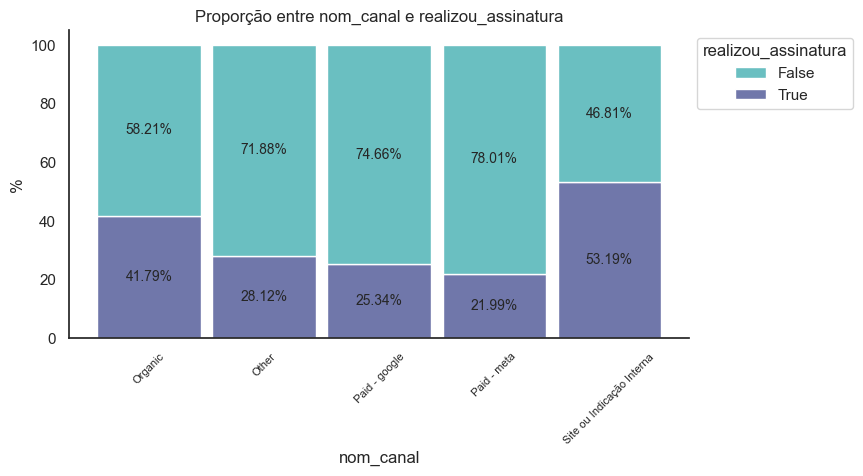

In [153]:
lib.plot_relacao_entre_2cat(dataframe=df_trial_metricas, coluna1='nom_canal', coluna2='realizou_assinatura')

In [17]:
# Realizando o teste qui-quadrado.
teste_chi2(dataframe=df_trial_metricas, coluna1='nom_canal', coluna2='realizou_assinatura')

***** Realizando a teste de hipóteses qui-quadrado *****
* Premissas:
- As observações devem ser contagens ou frequências.
- Cada observação deve pertencer a uma única categoria.
- A amostra deve ser relativamente grande, com pelo menos 5 observações em cada célula e, no caso de poucos grupos, pelo menos 10.
- Os dados devem vir de uma amostra aleatória.
- As categorias das variáveis devem ser mutuamente exclusivas.

----- Hipóteses -----
H0 : as variáveis nom_canal e realizou_assinatura são independentes. As proporções são estatisticamente iguais.
Ha : as variáveis nom_canal e realizou_assinatura são dependentes. As proporções são estatisticamente diferentes.
Nível de significância de 0.05.
---------------------

Valor do teste qui-quadrado: 27.633890295108593
P_valor: 1.4795704151988149e-05

----- Conclusão -----
- p_valor: 0.0000147957 < alpha: 0.05 => Rejeitamos a hipótese nula. Há evidência suficiente, ao nível de significância de 0.05, para concluir que as variáveis nom_canal e r

In [18]:
# Intervalo de confiança 
grpby_canal_conversao = lib.grpby_2cat(dataframe=df_trial_metricas, coluna1='nom_canal', coluna2='realizou_assinatura', plot=True)

freq = grpby_canal_conversao.loc[grpby_canal_conversao['realizou_assinatura']][['nom_canal','frequencia']]
nobs = grpby_canal_conversao.groupby(by=['nom_canal'], as_index=False)['frequencia'].sum().rename(columns={'frequencia':'nobs'})
freq_nobs = pd.merge(freq, nobs, on='nom_canal', how='left')
freq_nobs

,nom_canal,frequencia,nobs
0,Organic,28,67
1,Other,63,224
2,Paid - google,92,363
3,Paid - meta,62,282
4,Site ou Indicação Interna,25,47


In [19]:
# Itervalo de confiança.
for index, row in freq_nobs.iterrows():
    lower, upper = proportion_confint(count=row['frequencia'], nobs=row['nobs'], alpha=.05)
    print(f'Intervalo de confiança 95% para {row['nom_canal']}: [{lower*100:.3f}%, {upper*100:.3f}%]')

Intervalo de confiança 95% para Organic: [29.981%, 53.601%]
Intervalo de confiança 95% para Other: [22.237%, 34.013%]
Intervalo de confiança 95% para Paid - google: [20.870%, 29.819%]
Intervalo de confiança 95% para Paid - meta: [17.152%, 26.820%]
Intervalo de confiança 95% para Site ou Indicação Interna: [38.926%, 67.457%]


In [20]:
grpby_canal_conversao.loc[grpby_canal_conversao['realizou_assinatura']]

,nom_canal,realizou_assinatura,frequencia,porcentagem
1,Organic,True,28,41.791045
3,Other,True,63,28.125000
5,Paid - google,True,92,25.344353
7,Paid - meta,True,62,21.985816
8,Site ou Indicação Interna,True,25,53.191489


2. Impacto do Credenciamento na Conversão
    * Hipótese Nula (H0): O credenciamento da clínica não tem impacto significativo na taxa de conversão para assinaturas pagas.
    * Hipótese Alternativa (HA): O credenciamento da clínica tem impacto significativo na taxa de conversão para assinaturas pagas.
    
Teste Estatístico: Teste T para amostras independentes ou Teste de Qui-Quadrado.

In [23]:
lib.grpby_2cat(dataframe=df_trial_metricas, coluna1='credenciamento_aprovado', coluna2='realizou_assinatura')

,credenciamento_aprovado,realizou_assinatura,frequencia,porcentagem
0,False,False,621,88.587732
1,False,True,80,11.412268
3,True,False,92,32.624113
2,True,True,190,67.375887


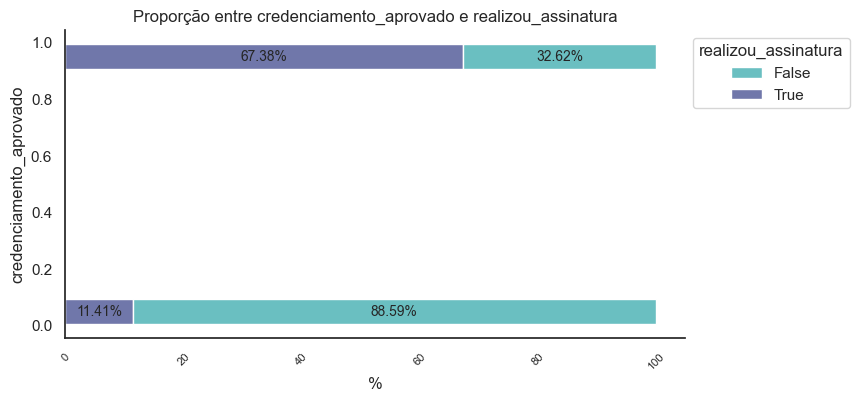

In [154]:
lib.plot_relacao_entre_2cat(dataframe=df_trial_metricas, coluna1='credenciamento_aprovado', coluna2='realizou_assinatura', orient='h')

In [26]:
# Realizando o teste qui-quadrado.
teste_chi2(dataframe=df_trial_metricas, coluna1='credenciamento_aprovado', coluna2='realizou_assinatura')

***** Realizando a teste de hipóteses qui-quadrado *****
* Premissas:
- As observações devem ser contagens ou frequências.
- Cada observação deve pertencer a uma única categoria.
- A amostra deve ser relativamente grande, com pelo menos 5 observações em cada célula e, no caso de poucos grupos, pelo menos 10.
- Os dados devem vir de uma amostra aleatória.
- As categorias das variáveis devem ser mutuamente exclusivas.

----- Hipóteses -----
H0 : as variáveis credenciamento_aprovado e realizou_assinatura são independentes. As proporções são estatisticamente iguais.
Ha : as variáveis credenciamento_aprovado e realizou_assinatura são dependentes. As proporções são estatisticamente diferentes.
Nível de significância de 0.05.
---------------------

Valor do teste qui-quadrado: 313.3368061990816
P_valor: 4.095776577602947e-70

----- Conclusão -----
- p_valor: 0.0000000000 < alpha: 0.05 => Rejeitamos a hipótese nula. Há evidência suficiente, ao nível de significância de 0.05, para concluir que 

In [27]:
grpby_credenciamento_conversao = lib.grpby_2cat(dataframe=df_trial_metricas, coluna1='credenciamento_aprovado', coluna2='realizou_assinatura', plot=True)
grpby_credenciamento_conversao

,credenciamento_aprovado,realizou_assinatura,frequencia,porcentagem
0,False,False,621,88.587732
1,False,True,80,11.412268
3,True,False,92,32.624113
2,True,True,190,67.375887


In [28]:
# realizando o Teste T para proporção binomial - 2 amostras.
freq = grpby_credenciamento_conversao.loc[grpby_credenciamento_conversao['realizou_assinatura']][['credenciamento_aprovado','frequencia']]
nobs = grpby_credenciamento_conversao.groupby(by=['credenciamento_aprovado'], as_index=False)['frequencia'].sum().rename(columns={'frequencia':'nobs'})
freq_nobs = pd.merge(freq, nobs, on='credenciamento_aprovado', how='left')
freq_nobs

,credenciamento_aprovado,frequencia,nobs
0,False,80,701
1,True,190,282


In [29]:
z_stat,pvalue = proportions_ztest(count=[freq_nobs.loc[freq_nobs['credenciamento_aprovado']]['frequencia'],freq_nobs.loc[~freq_nobs['credenciamento_aprovado']]['frequencia']],
                                   nobs=[freq_nobs.loc[freq_nobs['credenciamento_aprovado']]['nobs'],freq_nobs.loc[~freq_nobs['credenciamento_aprovado']]['nobs']])
print(z_stat)
print(pvalue)

[17.78031543]
[1.00413486e-70]


In [30]:
# Itervalo de confiança.
for index, row in freq_nobs.iterrows():
    lower, upper = proportion_confint(count=row['frequencia'], nobs=row['nobs'], alpha=.05)
    print(f'Intervalo de confiança 95% para Credenciamento aprovado {row['credenciamento_aprovado']}: [{lower*100:.3f}%, {upper*100:.3f}%]')

Intervalo de confiança 95% para Credenciamento aprovado False: [9.059%, 13.766%]
Intervalo de confiança 95% para Credenciamento aprovado True: [61.904%, 72.848%]


In [34]:
grpby_credenciamento_conversao.loc[grpby_credenciamento_conversao['realizou_assinatura']]

,credenciamento_aprovado,realizou_assinatura,frequencia,porcentagem
1,False,True,80,11.412268
2,True,True,190,67.375887


3. Número de Atividades e Conversão
    * Hipótese Nula (H0): O número de atividades realizadas durante o trial não influencia significativamente a conversão para assinaturas pagas.
    * Hipótese Alternativa (HA): O número de atividades realizadas durante o trial influencia significativamente a conversão para assinaturas pagas.

Teste Estatístico: Correlação de Pearson para verificar a relação entre o número de atividades e a taxa de conversão, ou um teste T para comparar a média de atividades entre os grupos que converteram e não converteram.

In [193]:
lib.grpby_difmedia_2amostras(dataframe=df_trial_metricas, coluna1='realizou_assinatura', coluna2='total_atividades_realizadas')

,realizou_assinatura,count,mean
0,False,713,4.932679
1,True,270,17.325926


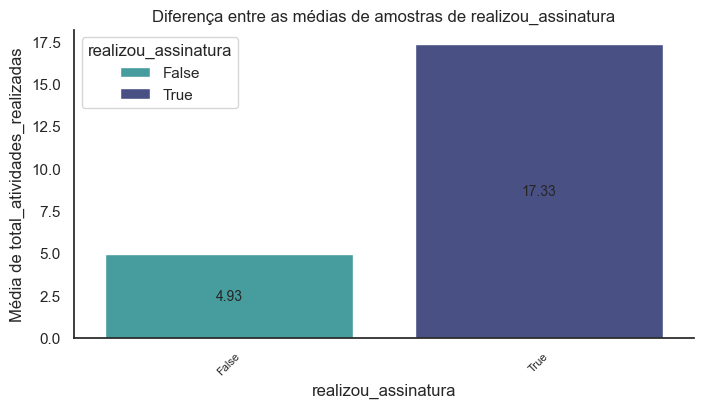

In [201]:
lib.plot_difmedia_2amostras(dataframe=df_trial_metricas, coluna1='realizou_assinatura', coluna2='total_atividades_realizadas')

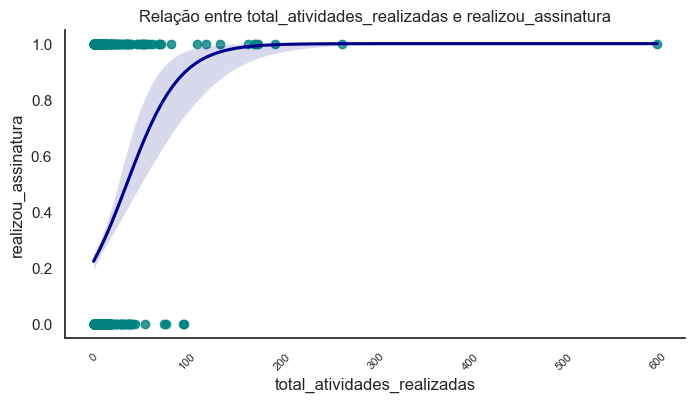

In [124]:
lib.plot_relacao_2variaveis(dataframe=df_trial_metricas, coluna_x='total_atividades_realizadas', coluna_y='realizou_assinatura', logistic=True)

In [195]:
# Correlação Pearson entre as variáveis.
df_trial_metricas[['total_atividades_realizadas','realizou_assinatura']].corr()

,total_atividades_realizadas,realizou_assinatura
total_atividades_realizadas,1.000000,0.204041
realizou_assinatura,0.204041,1.000000


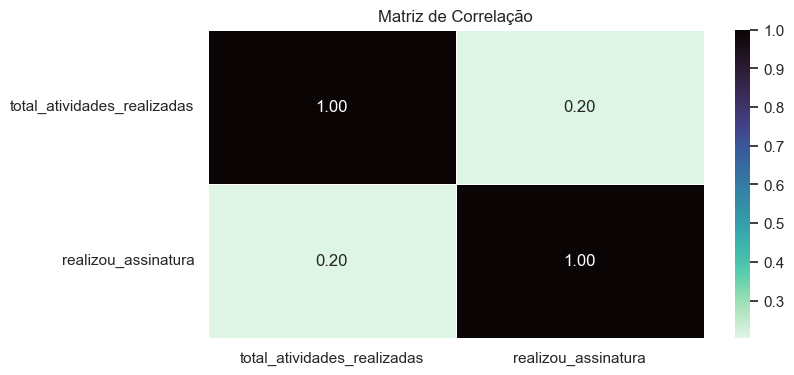


----- Hipóteses ---------------------------------------------------------------------------------
H0 : p = 0 => Não existe correlação significativa entre as variáveis.
Ha : p ≠ 0 => Existe correlação significativa entre as variáveis.
Nível de significância de 0.05.
-------------------------------------------------------------------------------------------------

----- Resultados -----
Coeficiente de Pearson p: 0.2040412670161802
P_valor: 1.066720333734921e-10

----- Conclusão -----
- p_valor: 0.000000000106672033373492101577 < alpha: 0.05 | coeficiente de Pearson: 0.2040 ≠ 0 => Rejeitamos a hipótese nula e concluimos que existe uma correlação estatisticamente significativa entre as variáveis total_atividades_realizadas e realizou_assinatura.


In [223]:
pearson_corr(dataframe=df_trial_metricas, coluna1='total_atividades_realizadas', coluna2='realizou_assinatura')

In [198]:
lib.grpby_difmedia_2amostras(dataframe=df_trial_metricas, coluna1='realizou_assinatura', coluna2='total_atividades_realizadas')

,realizou_assinatura,count,mean
0,False,713,4.932679
1,True,270,17.325926


In [134]:
realizou_assinatura_total_atividades = df_trial_metricas.loc[df_trial_metricas['realizou_assinatura']]['total_atividades_realizadas']

In [135]:
nao_realizou_assinatura_total_atividades = df_trial_metricas.loc[~df_trial_metricas['realizou_assinatura']]['total_atividades_realizadas']

In [136]:
# Verificar as variancias populacionais dos grupos.
variancia(data=df_trial_metricas, dv='total_atividades_realizadas', fator='realizou_assinatura')

***** Realizando o teste de hipóteses Bartlett de igualdade de variâncias. *****
* Premissas:
- Dados sejam normais ou que tenhamos pelo menos 15 dados em cada grupo.

----- Hipóteses -------------------------------------------------------------------------
H0 : As variâncias de todas as amostras da realizou_assinatura são iguais.
Ha : As variâncias para um par ou mais das amostras da realizou_assinatura são diferentes.
Nível de significância de 0.05.
-----------------------------------------------------------------------------------------

----- Resultados -----
Valor do estatística T: 1198.1473838393365
P_valor: 1.541432696911616e-262

----- Conclusão -----
- p_valor: 1.541432696911616e-262 < alpha: 0.05 => Rejeitamos a hipótese nula. As variâncias das amostras da realizou_assinatura são diferentes.


In [137]:
# Intervalo de confiança diferença duas médias - variâncias diferentes.
cm = sms.CompareMeans(sms.DescrStatsW(realizou_assinatura_total_atividades), sms.DescrStatsW(nao_realizou_assinatura_total_atividades))
cm.tconfint_diff(usevar='unequal')

(6.541542181791409, 18.24495202630168)

In [39]:
# Teste de hipóteses T - variâncias diferentes.
difmedia_2amostras(realizou_assinatura=realizou_assinatura_total_atividades, nao_realizou_assinatura=nao_realizou_assinatura_total_atividades, var='total_atividades_realizadas')

***** Realizando o teste de hipóteses t : Média - 2 amostras *****
* Premissas:
- Dados sejam normais ou que tenhamos pelo menos 15 dados em cada grupo.
- Grupos com variâncias diferentes.

----- Hipóteses ----------------------------------------------------------------
H0 : A média do total_atividades_realizadas entre realizou_assinatura e nao_realizou_assinatura, são iguais.
Ha : A média do total_atividades_realizadas entre realizou_assinatura e nao_realizou_assinatura, são diferentes.
Nível de significância de 0.05.
--------------------------------------------------------------------------------

----- Resultados -----
Valor do estatística T: 4.169249467080342
P_valor: 4.094085528e-05
Intervalo de confiança para diferença das médias: [ 6.54 18.24]

----- Conclusão -----
- p_valor: 4.094085528e-05 < alpha: 0.05 => Rejeitamos a hipótese nula. Existe diferença estatisticamente significativa das médias do total_atividades_realizadas entre realizou_assinatura e nao_realizou_assinatura.
-

4. Funcionalidades Usadas e Conversão
    * Hipótese Nula (H0): O uso de funcionalidades específicas (como prontuário, agendamento, gestão financeira) não influencia significativamente a conversão para assinaturas pagas.
    * Hipótese Alternativa (HA): O uso de funcionalidades específicas influencia significativamente a conversão para assinaturas pagas.

Teste Estatístico: Teste de Qui-Quadrado para verificar a associação entre o uso de funcionalidades e a conversão.

In [140]:
funcionalidade_conversao = pd.merge(df_funcionalidade_metricas, df_trial_metricas[['id_clinica','realizou_assinatura']], on='id_clinica', how='left')
funcionalidade_conversao

,id_clinica,id_funcionalidade,num_qtde_vezes,nom_funcionalidade,realizou_assinatura
0,8994,5,1,budget_management,False
1,8994,2,2,medical_record,False
2,8994,9,1,revenue_management,False
3,8994,1,1,scheduling,False
4,8998,3,2,anamnese,False
...,...,...,...,...,...
2294,11295,0,2,patient_management,False
2295,11295,1,1,scheduling,False
2296,11296,1,1,scheduling,False
2297,11301,1,1,scheduling,False


In [147]:
lib.grpby_2cat(dataframe=funcionalidade_conversao, coluna1='nom_funcionalidade', coluna2='realizou_assinatura')

,nom_funcionalidade,realizou_assinatura,frequencia,porcentagem
0,anamnese,False,196,69.257951
1,anamnese,True,87,30.742049
3,bnpl,False,1,14.285714
2,bnpl,True,6,85.714286
4,budget_management,False,203,69.047619
5,budget_management,True,91,30.952381
7,credit_check,False,12,40.000000
6,credit_check,True,18,60.000000
8,documents_and_files,False,82,71.304348
9,documents_and_files,True,33,28.695652


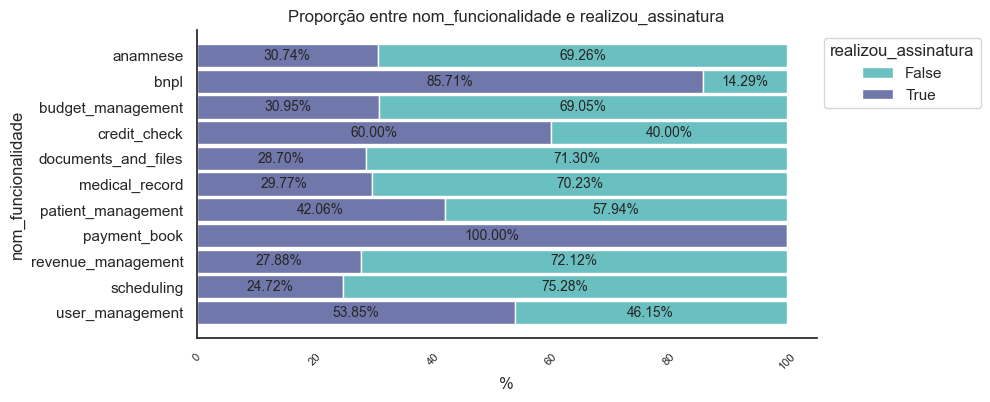

In [149]:
lib.plot_relacao_entre_2cat(dataframe=funcionalidade_conversao, coluna1='nom_funcionalidade', coluna2='realizou_assinatura', orient='h')

In [148]:
grpby_funcionalidades_conversao = lib.grpby_2cat(dataframe=funcionalidade_conversao, coluna1='nom_funcionalidade', coluna2='realizou_assinatura', plot=True)

In [150]:
# Realizando o teste qui-quadrado.
teste_chi2(dataframe=funcionalidade_conversao, coluna1='nom_funcionalidade', coluna2='realizou_assinatura')

***** Realizando a teste de hipóteses qui-quadrado *****
* Premissas:
- As observações devem ser contagens ou frequências.
- Cada observação deve pertencer a uma única categoria.
- A amostra deve ser relativamente grande, com pelo menos 5 observações em cada célula e, no caso de poucos grupos, pelo menos 10.
- Os dados devem vir de uma amostra aleatória.
- As categorias das variáveis devem ser mutuamente exclusivas.

----- Hipóteses -----
H0 : as variáveis nom_funcionalidade e realizou_assinatura são independentes. As proporções são estatisticamente iguais.
Ha : as variáveis nom_funcionalidade e realizou_assinatura são dependentes. As proporções são estatisticamente diferentes.
Nível de significância de 0.05.
---------------------

Valor do teste qui-quadrado: 76.92707229506287
P_valor: 2.003545134135274e-12

----- Conclusão -----
- p_valor: 0.0000000000 < alpha: 0.05 => Rejeitamos a hipótese nula. Há evidência suficiente, ao nível de significância de 0.05, para concluir que as variáve

In [151]:
# Intervalo de confiança 
freq = grpby_funcionalidades_conversao.loc[grpby_funcionalidades_conversao['realizou_assinatura']][['nom_funcionalidade','frequencia']]
nobs = grpby_funcionalidades_conversao.groupby(by=['nom_funcionalidade'], as_index=False)['frequencia'].sum().rename(columns={'frequencia':'nobs'})
freq_nobs = pd.merge(freq, nobs, on='nom_funcionalidade', how='left')
freq_nobs

,nom_funcionalidade,frequencia,nobs
0,anamnese,87,283
1,bnpl,6,7
2,budget_management,91,294
3,credit_check,18,30
4,documents_and_files,33,115
5,medical_record,117,393
6,patient_management,53,126
7,payment_book,2,2
8,revenue_management,58,208
9,scheduling,179,724


In [152]:
# Itervalo de confiança.
for index, row in freq_nobs.iterrows():
    lower, upper = proportion_confint(count=row['frequencia'], nobs=row['nobs'], alpha=.05)
    print(f'Intervalo de confiança 95% para {row['nom_funcionalidade']}: [{lower*100:.3f}%, {upper*100:.3f}%]')

Intervalo de confiança 95% para anamnese: [25.366%, 36.118%]
Intervalo de confiança 95% para bnpl: [59.792%, 100.000%]
Intervalo de confiança 95% para budget_management: [25.668%, 36.237%]
Intervalo de confiança 95% para credit_check: [42.470%, 77.530%]
Intervalo de confiança 95% para documents_and_files: [20.428%, 36.963%]
Intervalo de confiança 95% para medical_record: [25.250%, 34.292%]
Intervalo de confiança 95% para patient_management: [33.444%, 50.683%]
Intervalo de confiança 95% para payment_book: [100.000%, 100.000%]
Intervalo de confiança 95% para revenue_management: [21.790%, 33.979%]
Intervalo de confiança 95% para scheduling: [21.581%, 27.866%]
Intervalo de confiança 95% para user_management: [44.813%, 62.879%]


In [156]:
grpby_funcionalidades_conversao.loc[grpby_funcionalidades_conversao['realizou_assinatura']]

,nom_funcionalidade,realizou_assinatura,frequencia,porcentagem
1,anamnese,True,87,30.742049
2,bnpl,True,6,85.714286
5,budget_management,True,91,30.952381
6,credit_check,True,18,60.000000
9,documents_and_files,True,33,28.695652
11,medical_record,True,117,29.770992
13,patient_management,True,53,42.063492
14,payment_book,True,2,100.000000
16,revenue_management,True,58,27.884615
18,scheduling,True,179,24.723757


5. Duração do Trial e Conversão
    * Hipótese Nula (H0): A duração do período de trial não tem impacto significativo na taxa de conversão.
    * Hipótese Alternativa (HA): A duração do período de trial tem impacto significativo na taxa de conversão.

Teste Estatístico: Teste T para duas amostras independentes, comparando as durações de trial entre clínicas que converteram e não converteram.

In [188]:
lib.grpby_difmedia_2amostras(dataframe=df_trial_metricas, coluna1='realizou_assinatura', coluna2='num_dias_trial')

,realizou_assinatura,count,mean
0,False,713,9.423562
1,True,270,6.466667


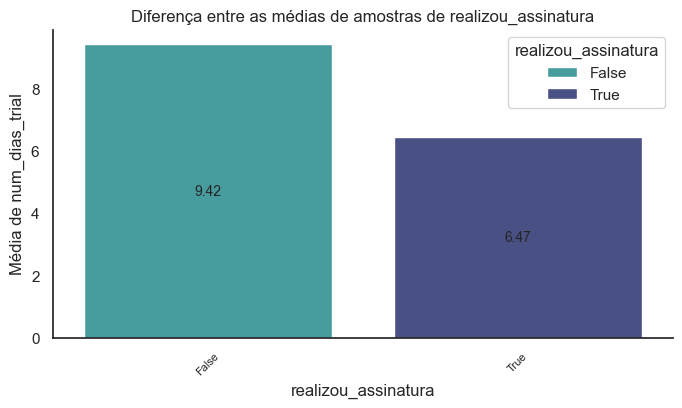

In [202]:
lib.plot_difmedia_2amostras(dataframe=df_trial_metricas, coluna1='realizou_assinatura', coluna2='num_dias_trial')

In [158]:
# Média e variância da duração do tempo de Trial.
grpby_conversao_duracao_trial = lib.grpby_difmedia_2amostras(dataframe=df_trial_metricas, coluna1='realizou_assinatura', coluna2='num_dias_trial', plot=True)

In [160]:
converteu_duracao_trial = df_trial_metricas.loc[df_trial_metricas['realizou_assinatura']]['num_dias_trial']
nao_converteu_duracao_trial = df_trial_metricas.loc[~df_trial_metricas['realizou_assinatura']]['num_dias_trial']

In [161]:
# Verificar as variancias populacionais dos grupos.
variancia(data=df_trial_metricas, dv='num_dias_trial', fator='realizou_assinatura')

***** Realizando o teste de hipóteses Bartlett de igualdade de variâncias. *****
* Premissas:
- Dados sejam normais ou que tenhamos pelo menos 15 dados em cada grupo.

----- Hipóteses -------------------------------------------------------------------------
H0 : As variâncias de todas as amostras da realizou_assinatura são iguais.
Ha : As variâncias para um par ou mais das amostras da realizou_assinatura são diferentes.
Nível de significância de 0.05.
-----------------------------------------------------------------------------------------

----- Resultados -----
Valor do estatística T: 305.0680173597413
P_valor: 2.5920974956059793e-68

----- Conclusão -----
- p_valor: 2.5920974956059793e-68 < alpha: 0.05 => Rejeitamos a hipótese nula. As variâncias das amostras da realizou_assinatura são diferentes.


In [162]:
# Intervalo de confiança diferença duas médias - variâncias diferentes.
cm = sms.CompareMeans(sms.DescrStatsW(converteu_duracao_trial), sms.DescrStatsW(nao_converteu_duracao_trial))
cm.tconfint_diff(usevar='unequal')

(-4.647257627184542, -1.2665338641665564)

In [163]:
# Teste de hipóteses T - variâncias diferentes.
difmedia_2amostras(realizou_assinatura=converteu_duracao_trial, nao_realizou_assinatura=nao_converteu_duracao_trial, var='num_dias_trial')

***** Realizando o teste de hipóteses t : Média - 2 amostras *****
* Premissas:
- Dados sejam normais ou que tenhamos pelo menos 15 dados em cada grupo.
- Grupos com variâncias diferentes.

----- Hipóteses ----------------------------------------------------------------
H0 : A média do num_dias_trial entre realizou_assinatura e nao_realizou_assinatura, são iguais.
Ha : A média do num_dias_trial entre realizou_assinatura e nao_realizou_assinatura, são diferentes.
Nível de significância de 0.05.
--------------------------------------------------------------------------------

----- Resultados -----
Valor do estatística T: -3.432768718087284
P_valor: 0.000622599020828
Intervalo de confiança para diferença das médias: [-4.65 -1.27]

----- Conclusão -----
- p_valor: 0.000622599020828 < alpha: 0.05 => Rejeitamos a hipótese nula. Existe diferença estatisticamente significativa das médias do num_dias_trial entre realizou_assinatura e nao_realizou_assinatura.
- Intervalo de confiança [-4.65 -1.

6. Tempo Médio para Conversão e Atividades Realizadas
    * Hipótese Nula (H0): O tempo médio para conversão não é influenciado pelo número de atividades realizadas.
    * Hipótese Alternativa (H1): O tempo médio para conversão é influenciado pelo número de atividades realizadas.
    
Teste Estatístico: Correlação de Pearson para analisar a relação entre o tempo para conversão e o número de atividades.

In [54]:
df_trial_metricas.loc[df_trial_metricas['realizou_assinatura']]['num_dias_para_assinatura'].mean()

9.311111111111112

In [175]:
lib.grpby_difmedia_2amostras(dataframe=df_trial_metricas.loc[df_trial_metricas['realizou_assinatura']], coluna1='total_atividades_realizadas', coluna2='num_dias_para_assinatura')

,total_atividades_realizadas,count,mean
0,0,53,11.396226
1,1,53,8.962264
2,2,20,7.300000
3,3,9,7.222222
4,4,13,8.461538
5,5,8,15.250000
6,6,10,5.700000
7,7,5,9.600000
8,8,5,8.600000
9,9,5,11.600000


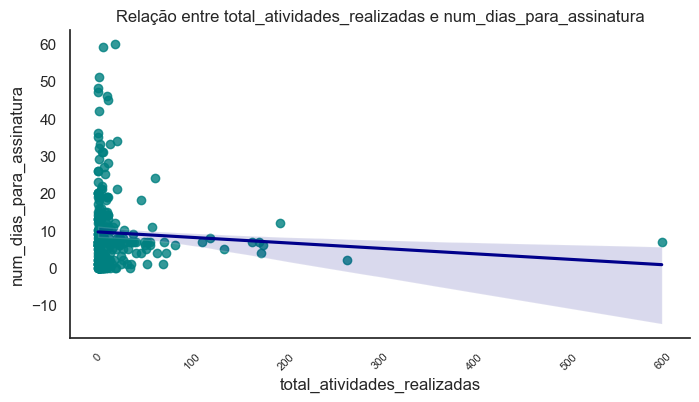

In [177]:
lib.plot_relacao_2variaveis(dataframe=df_trial_metricas.loc[df_trial_metricas['realizou_assinatura']], coluna_x='total_atividades_realizadas', coluna_y='num_dias_para_assinatura')

In [178]:
df_trial_metricas.loc[df_trial_metricas['realizou_assinatura']][['total_atividades_realizadas','num_dias_para_assinatura']].corr()

,total_atividades_realizadas,num_dias_para_assinatura
total_atividades_realizadas,1.000000,-0.068078
num_dias_para_assinatura,-0.068078,1.000000


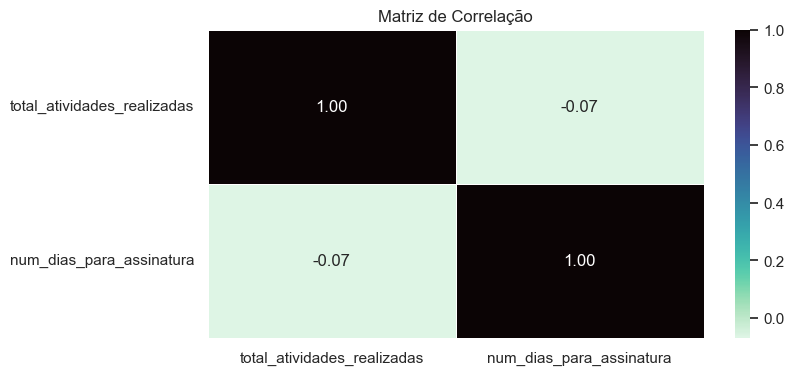


----- Hipóteses ---------------------------------------------------------------------------------
H0 : p = 0 => Não existe correlação significativa entre as variáveis.
Ha : p ≠ 0 => Existe correlação significativa entre as variáveis.
Nível de significância de 0.05.
-------------------------------------------------------------------------------------------------

----- Resultados -----
Coeficiente de Pearson p: -0.06807824865064005
P_valor: 0.2649603206365412

----- Conclusão -----
- p_valor: 0.264960320636541180050471666618 > alpha: 0.05 | coeficiente de Pearson: -0.0681 = 0 => Não rejeitamos a hipótese nula e concluimos que não existe uma correlação estatisticamente significativa entre as variáveis total_atividades_realizadas e num_dias_para_assinatura.


In [224]:
pearson_corr(dataframe=df_trial_metricas.loc[df_trial_metricas['realizou_assinatura']], coluna1='total_atividades_realizadas', coluna2='num_dias_para_assinatura')

7. Impacto da Fonte de Aquisição no Tempo para Conversão
    * Hipótese Nula (H0): O tempo para conversão não é significativamente diferente entre as fontes de aquisição.
    * Hipótese Alternativa (HA): O tempo para conversão é significativamente diferente entre as fontes de aquisição.
    
Teste Estatístico: ANOVA para comparar o tempo para conversão entre diferentes fontes de aquisição.

In [190]:
lib.grpby_difmedia_2amostras(dataframe=df_trial_metricas.loc[df_trial_metricas['realizou_assinatura']], coluna1='nom_canal', coluna2='num_dias_para_assinatura')

,nom_canal,count,mean
0,Organic,28,11.750000
1,Other,63,7.841270
2,Paid - google,92,9.684783
3,Paid - meta,62,9.693548
4,Site ou Indicação Interna,25,7.960000


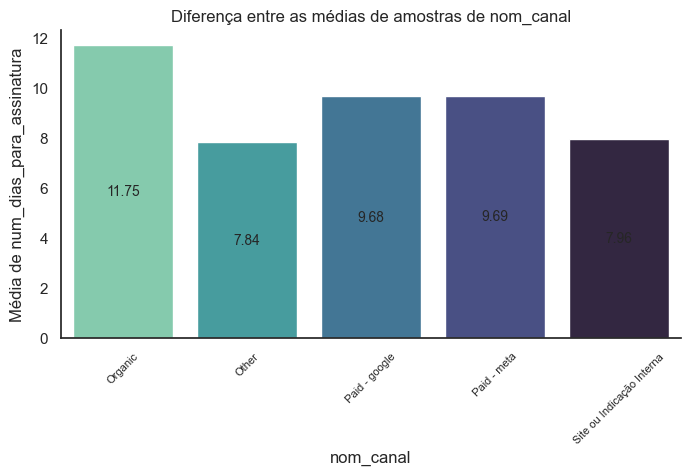

In [203]:
lib.plot_difmedia_2amostras(dataframe=df_trial_metricas.loc[df_trial_metricas['realizou_assinatura']], coluna1='nom_canal', coluna2='num_dias_para_assinatura')

In [204]:
# Verificar as variancias populacionais dos grupos.
variancia(data=df_trial_metricas.loc[df_trial_metricas['realizou_assinatura']], dv='num_dias_para_assinatura', fator='nom_canal')

***** Realizando o teste de hipóteses Bartlett de igualdade de variâncias. *****
* Premissas:
- Dados sejam normais ou que tenhamos pelo menos 15 dados em cada grupo.

----- Hipóteses -------------------------------------------------------------------------
H0 : As variâncias de todas as amostras da nom_canal são iguais.
Ha : As variâncias para um par ou mais das amostras da nom_canal são diferentes.
Nível de significância de 0.05.
-----------------------------------------------------------------------------------------

----- Resultados -----
Valor do estatística T: 1.142223749433616
P_valor: 0.8875163763693666

----- Conclusão -----
- p_valor: 0.8875163763693666 > alpha: 0.05 => Não rejeitamos a hipótese nula. As variâncias das amostras da nom_canal são iguais.


In [205]:
# Variância estatisticamente iguais. 
# Teste de hipóteste ANOVA oneway
anova(dv='num_dias_para_assinatura', fator='nom_canal', data=df_trial_metricas.loc[df_trial_metricas['realizou_assinatura']], var_iguais=True)

***** Realizando o teste de hipóteses ANOVA : Médias : +2 amostras : 1 fator *****
* Premissas:
- Amostras aleatórias.
- Grupos independentes.
- Variável dependente é continua.
- Variável independente é categórica.
- Dados sejam normais ou que tenhamos pelo menos 15 dados em cada grupo.
- Grupos com variâncias iguais.

----- Hipóteses -----------------------------------------------------------------------
H0 : As médias da num_dias_para_assinatura entre as amostras da nom_canal são iguais.
Ha : As médias da num_dias_para_assinatura entre as amostras da nom_canal são diferentes.
Nível de significância de 0.05.
---------------------------------------------------------------------------------------

----- Resultados -----
Valor do estatística F: 0.8483763311044628
P_valor: 0.49563315910278916

----- Conclusão -----
- p_valor: 0.49563315910278916 > alpha: 0.05 => Não rejeitamos a hipótese nula. Não existe diferença estatisticamente significativa das médias do num_dias_para_assinatura entre

In [206]:
# Posthoc Anova - Verificar quais pares de amostras tem as médias estatisticamente diferentes.
posthoc(dv='num_dias_para_assinatura', fator='nom_canal', data=df_trial_metricas.loc[df_trial_metricas['realizou_assinatura']], var_iguais=True)

***** Post-Hoc ANOVA - Realizando o teste de hipóteses Tukey para explorar a diferença entre as médias de vários grupos (pares). *****
* Premissas:
- Amostras aleatórias.
- Grupos independentes.
- Dados sejam normais ou que tenhamos pelo menos 15 dados em cada grupo.
- Grupos com variâncias iguais.
- Tamanhos de amostras de todos os grupos são iguais.

----- Hipóteses ---------------------------------------------------------------------------------
H0 : As médias da num_dias_para_assinatura entre os pares das amostras da nom_canal são iguais.
Ha : As médias da num_dias_para_assinatura entre os pares das amostras da nom_canal são diferentes.
Nível de significância de 0.05.
-------------------------------------------------------------------------------------------------

----- Resultados -----
- Pares de amostras com médias estatisticamente iguais - p_valor > alpha: 0.05 - Não rejeitamos H0


,A,mean(A),B,mean(B),p-valor
0,Organic,11.750000,Other,7.841270,0.468379
1,Organic,11.750000,Paid - google,9.684783,0.890543
2,Organic,11.750000,Paid - meta,9.693548,0.909509
3,Organic,11.750000,Site ou Indicação Interna,7.960000,0.679814
4,Other,7.841270,Paid - google,9.684783,0.817085
5,Other,7.841270,Paid - meta,9.693548,0.859105
6,Other,7.841270,Site ou Indicação Interna,7.960000,0.999999
7,Paid - google,9.684783,Paid - meta,9.693548,1.000000
8,Paid - google,9.684783,Site ou Indicação Interna,7.960000,0.948843
9,Paid - meta,9.693548,Site ou Indicação Interna,7.960000,0.956228



- Pares de amostras com médias estatisticamente diferentes - p_valor < alpha: 0.05 - Rejeitamos H0


,A,mean(A),B,mean(B),p-valor


8. Abandono durante o Trial
    * Hipótese Nula (H0): O número de atividades realizadas durante o trial não influencia significativamente as clínicas que abandonam o produto durante o trial e aquelas abandonam o produto após o trial.
    * Hipótese Alternativa (HA): O número de atividades realizadas durante o trial não influencia significativamente as clínicas que abandonam o produto durante o trial e aquelas abandonam o produto após o trial.
    
Teste Estatístico: Teste T para duas amostras independentes.

In [207]:
total_atividades_churn_durante_trial = df_trial_metricas.loc[~df_trial_metricas['realizou_assinatura']]['id_clinica']
total_atividades_churn_apos_trial = df_trial_metricas.loc[df_trial_metricas['realizou_assinatura'] & (df_trial_metricas['status_assinatura'] != 'active')]['id_clinica']

In [208]:
# Churn durante o Trial e após o Trial.
df_churn = df_trial_metricas[['id_clinica','total_atividades_realizadas']].loc[~df_trial_metricas['realizou_assinatura'] |
                                                                                (df_trial_metricas['realizou_assinatura'] & (df_trial_metricas['status_assinatura'] != 'active'))]

# Definição do tipo de Churn.
df_churn['tipo_churn'] = np.where(df_churn['id_clinica'].isin(total_atividades_churn_durante_trial), 'Durante o Trial', 'Após o Trial')

df_churn

,id_clinica,total_atividades_realizadas,tipo_churn
1,9984,14,Durante o Trial
2,9986,4,Durante o Trial
3,9988,1,Durante o Trial
4,9690,1,Durante o Trial
7,9991,2,Durante o Trial
...,...,...,...
974,11291,0,Durante o Trial
977,10459,7,Durante o Trial
978,9011,0,Durante o Trial
980,11146,0,Durante o Trial


In [209]:
lib.grpby_difmedia_2amostras(dataframe=df_churn, coluna1='tipo_churn', coluna2='total_atividades_realizadas')

,tipo_churn,count,mean
0,Após o Trial,29,34.689655
1,Durante o Trial,713,4.932679


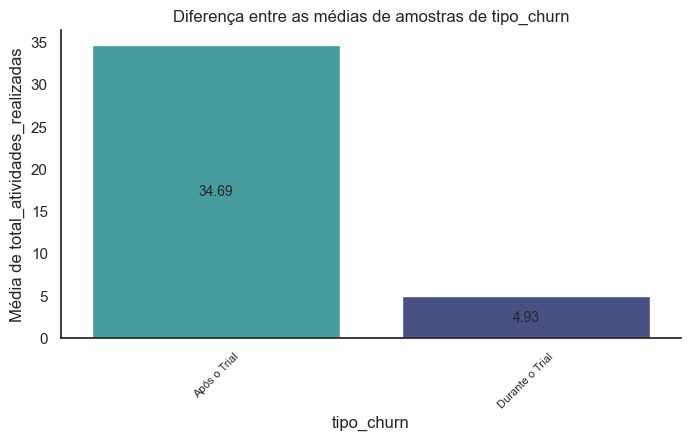

In [210]:
lib.plot_difmedia_2amostras(dataframe=df_churn, coluna1='tipo_churn', coluna2='total_atividades_realizadas')

In [211]:
# Verificar as variancias populacionais dos grupos.
variancia(data=df_churn, dv='total_atividades_realizadas', fator='tipo_churn')

***** Realizando o teste de hipóteses Bartlett de igualdade de variâncias. *****
* Premissas:
- Dados sejam normais ou que tenhamos pelo menos 15 dados em cada grupo.

----- Hipóteses -------------------------------------------------------------------------
H0 : As variâncias de todas as amostras da tipo_churn são iguais.
Ha : As variâncias para um par ou mais das amostras da tipo_churn são diferentes.
Nível de significância de 0.05.
-----------------------------------------------------------------------------------------

----- Resultados -----
Valor do estatística T: 1240.7227445252681
P_valor: 8.614550060923065e-272

----- Conclusão -----
- p_valor: 8.614550060923065e-272 < alpha: 0.05 => Rejeitamos a hipótese nula. As variâncias das amostras da tipo_churn são diferentes.


In [212]:
churn_durante_trial = df_churn.loc[df_churn['tipo_churn'] == 'Durante o Trial']['total_atividades_realizadas']
churn_apos_trial = df_churn.loc[df_churn['tipo_churn'] == 'Após o Trial']['total_atividades_realizadas']

In [200]:
import importlib
importlib.reload(lib)
lib.colormap = 'mako_r'

In [213]:
# Intervalo de confiança diferença duas médias - variâncias diferentes.
cm = sms.CompareMeans(sms.DescrStatsW(churn_durante_trial), sms.DescrStatsW(churn_apos_trial))
cm.tconfint_diff(usevar='unequal')

(-72.04110629499601, 12.527153593927185)

In [214]:
# Teste de hipóteses T - variâncias diferentes.
difmedia_2amostras(churn_durante_trial=churn_durante_trial, churn_apos_trial=churn_apos_trial, var='total_atividades_realizadas')

***** Realizando o teste de hipóteses t : Média - 2 amostras *****
* Premissas:
- Dados sejam normais ou que tenhamos pelo menos 15 dados em cada grupo.
- Grupos com variâncias diferentes.

----- Hipóteses ----------------------------------------------------------------
H0 : A média do total_atividades_realizadas entre churn_durante_trial e churn_apos_trial, são iguais.
Ha : A média do total_atividades_realizadas entre churn_durante_trial e churn_apos_trial, são diferentes.
Nível de significância de 0.05.
--------------------------------------------------------------------------------

----- Resultados -----
Valor do estatística T: -1.441507780430825
P_valor: 0.160526886069243
Intervalo de confiança para diferença das médias: [-72.04  12.53]

----- Conclusão -----
- p_valor: 0.160526886069243 > alpha: 0.05 => Não rejeitamos a hipótese nula. Não existe diferença estatisticamente significativa das médias do total_atividades_realizadas entre churn_durante_trial e churn_apos_trial.
- Inter